# Build an EOF base from the ensemble mean hist+rcp8.5 then project individual experiments on that base 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xhistogram.xarray import histogram
import glob
from decimal import Decimal
from eofs.xarray import Eof
from functions import bin_TS

In [3]:
plt.style.use('ggplot')

In [4]:
reso = [0.01,0.02,0.025,0.03,0.04,0.05,0.1]
c = 10
deltaS = reso[1]
deltaT = c*deltaS
sbins = np.arange(30,40, deltaS) 
tbins = np.arange(-2, 33, deltaT)
region='global'

In [13]:
def red_zeros(V):
    """Center and reduce array, then replace nans with zeros (nans come from dividing by zero in the reduction)"""
    V_red = V - V.mean(dim='time')
    V_red = V_red/V.std(dim='time')
    V_red = xr.where(np.isnan(V_red)==False,V_red,0)
    return V_red

In [6]:
# -- Read ensemble mean hist+rcp8.5
dir = '/data/ysilvy/bin_TS/'
Vensm = xr.open_dataset(glob.glob(dir+'*ensm*.nc')[0]).histogram_so_thetao

In [14]:
# -- Center and reduce data prior to performing EOF
Vensm_red = red_zeros(Vensm)

In [16]:
# -- Perform EOF 
solver=Eof(Vensm_red.stack(z=('so_bin','thetao_bin')))
pcs = solver.pcs()
eofs = solver.eofs()
var1 = solver.varianceFraction()[0].data*100
var2 = solver.varianceFraction()[1].data*100
var3 = solver.varianceFraction()[2].data*100
eof1 = eofs[0,:].unstack('z')
eof2 = eofs[1,:].unstack('z')
eof3 = eofs[2,:].unstack('z')

In [17]:
# -- Read each hist+rcp member
V1 = xr.open_dataset(dir+'volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r1i1p1_1850-2100.nc').histogram_so_thetao
V2 = xr.open_dataset(dir+'volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r2i1p1_1850-2100.nc').histogram_so_thetao
V3 = xr.open_dataset(dir+'volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r3i1p1_1850-2100.nc').histogram_so_thetao
V4 = xr.open_dataset(dir+'volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_historical-rcp85_r4i1p1_1850-2100.nc').histogram_so_thetao

In [18]:
# -- Center,reduce, zeros where nans
V1_red = red_zeros(V1)
V2_red = red_zeros(V2)
V3_red = red_zeros(V3)
V4_red = red_zeros(V4)

In [25]:
# -- Project each member on EOF base
pseudo_pcs_1 = solver.projectField(V1_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_2 = solver.projectField(V2_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_3 = solver.projectField(V3_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_4 = solver.projectField(V4_red.stack(z=('so_bin', 'thetao_bin')))

In [22]:
# -- Read piControl
dir4D = '/data/ysilvy/CMIP5_annual/4D/'
dsT_piC = xr.open_mfdataset(dir4D+'thetao*piControl*.nc',combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
dsS_piC = xr.open_mfdataset(dir4D+'so*piControl*.nc',combine='by_coords',data_vars='minimal',coords='minimal', compat='override')
dirvolpiC = '/bdd/CMIP5/output/IPSL/IPSL-CM5A-LR/piControl/fx/ocean/fx/r0i0p0/latest/volcello/'
dsvol_piC = xr.open_dataset(dirvolpiC+'volcello_fx_IPSL-CM5A-LR_piControl_r0i0p0.nc')
dsvol_piC = dsvol_piC.reindex(lev=list(dsT_piC.lev))
vol_piC = xr.Dataset({'volcello':(['lev','y','x'],dsvol_piC.volcello.data),
                'lon_vertices':(['y','x','vertices'],dsvol_piC.lon_vertices.data),
                'lat_vertices':(['y','x','vertices'],dsvol_piC.lat_vertices.data),
                'lev_bnds':(['lev','bnds'],dsvol_piC.lev_bnds.data)},
               coords={'lon': (['y', 'x'], dsvol_piC.lon.data),
                'lat': (['y', 'x'], dsvol_piC.lat.data),
                'lev':(['lev'], dsvol_piC.lev.data)})
# -- Bin volume piControl
VpiC = bin_TS(dsS_piC,dsT_piC,vol_piC,sbins,tbins)
# -- Divide in 4 chunks of 250 years each
VpiC1 = VpiC.isel(time=slice(0,250)).load()
VpiC2 = VpiC.isel(time=slice(250,500)).load()
VpiC3 = VpiC.isel(time=slice(500,750)).load()
VpiC4 = VpiC.isel(time=slice(750,1000)).load()
del dsS_piC, dsT_piC
# -- Center, reduce, zeros where nans
VpiC1_red = red_zeros(VpiC1)
VpiC2_red = red_zeros(VpiC2)
VpiC3_red = red_zeros(VpiC3)
VpiC4_red = red_zeros(VpiC4)

In [23]:
# -- Project piControl chunks on EOF base
pseudo_pcs_piC1 = solver.projectField(VpiC1_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC2 = solver.projectField(VpiC2_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC3 = solver.projectField(VpiC3_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC4 = solver.projectField(VpiC4_red.stack(z=('so_bin', 'thetao_bin')))

In [52]:
# -- Read 1pctCO2
VCO2 = xr.open_dataset(dir+'volumeTS_global_'+str(deltaS)+'_'+str(deltaT)+'_IPSL-CM5A-LR_1pctCO2_r1i1p1_1850-1989.nc').histogram_so_thetao
# -- Center, reduce, zeros where nans
VCO2_red = red_zeros(VCO2)
# -- Project 1pctCO2 on EOF base
pseudo_pcs_CO2 = solver.projectField(VCO2_red.stack(z=('so_bin', 'thetao_bin')))

In [36]:
ymin = np.min(np.array([pseudo_pcs_piC1[:,0].std(),pseudo_pcs_piC2[:,0].min(),pseudo_pcs_piC3[:,0].min(),pseudo_pcs_piC4[:,0].min()]))
ymax = np.max(np.array([pseudo_pcs_piC1[:,0].max(),pseudo_pcs_piC2[:,0].max(),pseudo_pcs_piC3[:,0].max(),pseudo_pcs_piC4[:,0].max()]))
stdmax = np.max(np.array([pseudo_pcs_piC1[:,0].std(),pseudo_pcs_piC2[:,0].std(),pseudo_pcs_piC3[:,0].std(),pseudo_pcs_piC4[:,0].std()]))
baseline = pcs[0:50,0].mean(dim='time')

Text(0.5, 0.98, 'global, historical+rcp85 ensemble mean\nResolution: deltaS=0.02 deltaT=0.2')

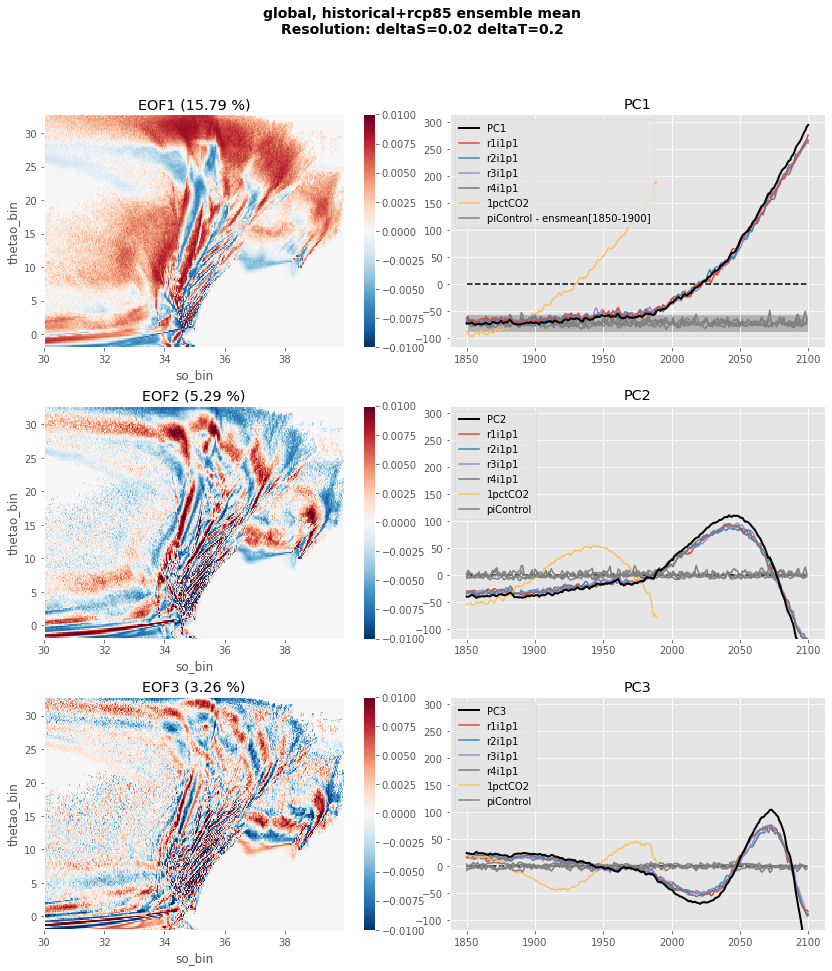

In [53]:
time=np.arange(1850,2101)
timehn = np.arange(1850,2013)
timepiC = np.arange(1850,2100)
timeCO2 = np.arange(1850,1990)
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

vmin = -0.01 
vmax = 0.01 

c = eof1.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1))+'%)')
ax[0,1].plot(time,pcs[:,0],label='PC1',lw=2,color='black',zorder=10)
ax[0,1].plot(time,pseudo_pcs_1[:,0],label='r1i1p1',zorder=9)
ax[0,1].plot(time,pseudo_pcs_2[:,0],label='r2i1p1',zorder=8)
ax[0,1].plot(time,pseudo_pcs_3[:,0],label='r3i1p1',zorder=7)
ax[0,1].plot(time,pseudo_pcs_4[:,0],label='r4i1p1',zorder=6)
ax[0,1].plot(timeCO2,pseudo_pcs_CO2[:,0],label='1pctCO2')
ax[0,1].plot(timepiC,pseudo_pcs_piC1[:,0]-abs(baseline),color='grey',label='piControl - ensmean[1850-1900]',zorder=5)
ax[0,1].plot(timepiC,pseudo_pcs_piC2[:,0]-abs(baseline),color='grey',zorder=4)
ax[0,1].plot(timepiC,pseudo_pcs_piC3[:,0]-abs(baseline),color='grey',zorder=3)
ax[0,1].plot(timepiC,pseudo_pcs_piC4[:,0]-abs(baseline),color='grey',zorder=2)
ax[0,1].fill_between(x=time,y1=baseline-3*stdmax,y2=baseline+3*stdmax,alpha=0.5,color='grey',zorder=0)
ax[0,1].legend()
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')
ylim = ax[0,1].get_ylim()

c = eof2.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2))+'%)')
ax[1,1].plot(time,pcs[:,1],label='PC2',lw=2,color='black',zorder=10)
ax[1,1].plot(time,pseudo_pcs_1[:,1],label='r1i1p1')
ax[1,1].plot(time,pseudo_pcs_2[:,1],label='r2i1p1')
ax[1,1].plot(time,pseudo_pcs_3[:,1],label='r3i1p1')
ax[1,1].plot(time,pseudo_pcs_4[:,1],label='r4i1p1')
ax[1,1].plot(timeCO2,pseudo_pcs_CO2[:,1],label='1pctCO2')
ax[1,1].plot(timepiC,pseudo_pcs_piC1[:,1],color='grey',label='piControl')
ax[1,1].plot(timepiC,pseudo_pcs_piC2[:,1],color='grey')
ax[1,1].plot(timepiC,pseudo_pcs_piC3[:,1],color='grey')
ax[1,1].plot(timepiC,pseudo_pcs_piC4[:,1],color='grey')
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')
ax[1,1].set_ylim(ylim[0],ylim[1])
ax[1,1].legend()

c = eof3.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3))+'%)')
ax[2,1].plot(time,pcs[:,2],label='PC3',lw=2,color='black',zorder=10)
ax[2,1].plot(time,pseudo_pcs_1[:,2],label='r1i1p1')
ax[2,1].plot(time,pseudo_pcs_2[:,2],label='r2i1p1')
ax[2,1].plot(time,pseudo_pcs_3[:,2],label='r3i1p1')
ax[2,1].plot(time,pseudo_pcs_4[:,2],label='r4i1p1')
ax[2,1].plot(timeCO2,pseudo_pcs_CO2[:,2],label='1pctCO2')
ax[2,1].plot(timepiC,pseudo_pcs_piC1[:,2],color='grey',label='piControl')
ax[2,1].plot(timepiC,pseudo_pcs_piC2[:,2],color='grey')
ax[2,1].plot(timepiC,pseudo_pcs_piC3[:,2],color='grey')
ax[2,1].plot(timepiC,pseudo_pcs_piC4[:,2],color='grey')
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')
ax[2,1].set_ylim(ylim[0],ylim[1])
ax[2,1].legend()

plt.subplots_adjust(hspace=0.25,wspace=0.08)
title = region+', historical+rcp85 ensemble mean\nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT)
plt.suptitle(title,fontsize=14,fontweight='bold')

## Same with temporal smoothing 

In [42]:
def smooth_red_zeros(V):
    Vsmooth = V.rolling(time=10,center=True,keep_attrs=True,min_periods=1).mean()
    V_red = Vsmooth - Vsmooth.mean(dim='time')
    V_red = V_red/V.std(dim='time')
    V_red = xr.where(np.isnan(V_red)==False,V_red,0)
    return V_red

In [43]:
# -- Now with temporal smoothing
Vensm_smooth_red = smooth_red_zeros(Vensm)
V1_smooth_red = smooth_red_zeros(V1)
V2_smooth_red = smooth_red_zeros(V2)
V3_smooth_red = smooth_red_zeros(V3)
V4_smooth_red = smooth_red_zeros(V4)

In [44]:
# -- Perform EOF 
solver_smooth=Eof(Vensm_smooth_red.stack(z=('so_bin','thetao_bin')))
pcs_smooth = solver_smooth.pcs()
eofs_smooth = solver_smooth.eofs()
var1_smooth = solver_smooth.varianceFraction()[0].data*100
var2_smooth = solver_smooth.varianceFraction()[1].data*100
var3_smooth = solver_smooth.varianceFraction()[2].data*100
eof1_smooth = eofs_smooth[0,:].unstack('z')
eof2_smooth = eofs_smooth[1,:].unstack('z')
eof3_smooth = eofs_smooth[2,:].unstack('z')

In [45]:
# -- Project each member on EOF base
pseudo_pcs_smooth_1 = solver_smooth.projectField(V1_smooth_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_smooth_2 = solver_smooth.projectField(V2_smooth_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_smooth_3 = solver_smooth.projectField(V3_smooth_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_smooth_4 = solver_smooth.projectField(V4_smooth_red.stack(z=('so_bin', 'thetao_bin')))

In [46]:
# -- Project each unsmoothed member
pseudo_pcs_1bis = solver_smooth.projectField(V1_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_2bis = solver_smooth.projectField(V2_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_3bis = solver_smooth.projectField(V3_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_4bis = solver_smooth.projectField(V4_red.stack(z=('so_bin', 'thetao_bin')))

In [47]:
# -- Project unsmoothed piControl
pseudo_pcs_piC1bis = solver_smooth.projectField(VpiC1_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC2bis = solver_smooth.projectField(VpiC2_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC3bis = solver_smooth.projectField(VpiC3_red.stack(z=('so_bin', 'thetao_bin')))
pseudo_pcs_piC4bis = solver_smooth.projectField(VpiC4_red.stack(z=('so_bin', 'thetao_bin')))

Text(0.5, 0.98, 'global, historical+rcp85 ensemble mean temporal smoothing 10 years\nResolution: deltaS=0.02 deltaT=0.2')

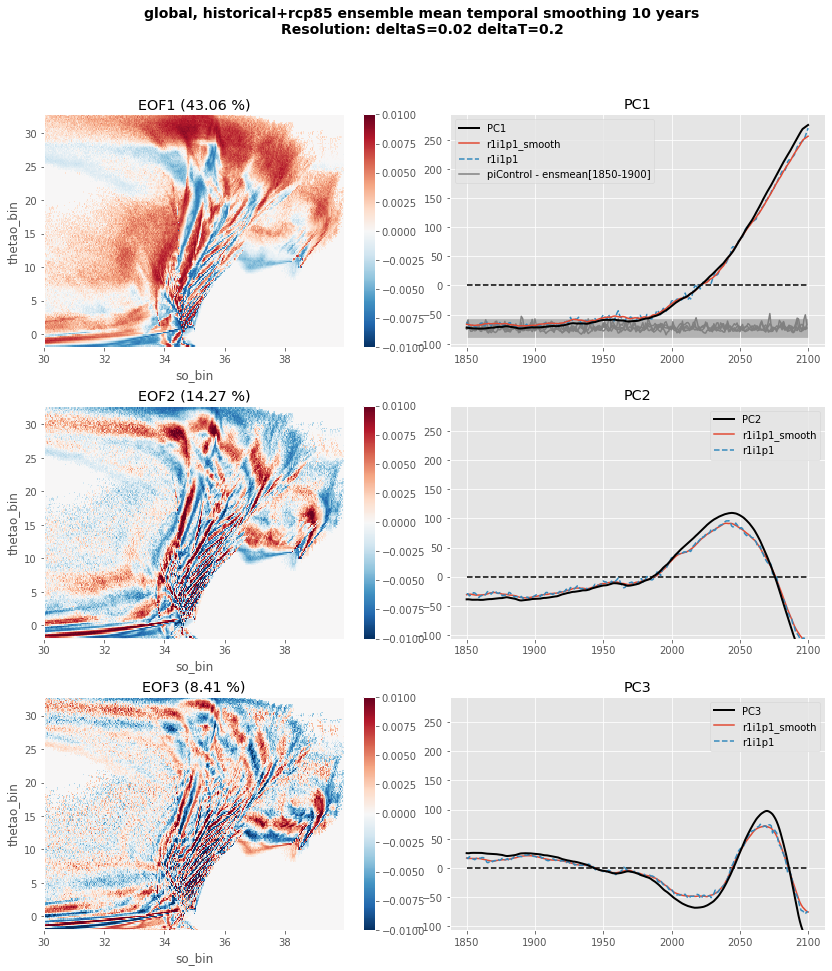

In [63]:
time=np.arange(1850,2101)

fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

vmin = -0.01 
vmax = 0.01 

c = eof1_smooth.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_smooth))+'%)')
ax[0,1].plot(time,pcs_smooth[:,0],label='PC1',lw=2,color='black',zorder=10)
ax[0,1].plot(time,pseudo_pcs_smooth_1[:,0],label='r1i1p1_smooth',zorder=9)
# ax[0,1].plot(time,pseudo_pcs_smooth_2[:,0],label='r2i1p1_smooth')
# ax[0,1].plot(time,pseudo_pcs_smooth_3[:,0],label='r3i1p1_smooth')
# ax[0,1].plot(time,pseudo_pcs_smooth_4[:,0],label='r4i1p1_smooth')
ax[0,1].plot(time,pseudo_pcs_1bis[:,0],label='r1i1p1',ls='--',zorder=8)
# ax[0,1].plot(time,pseudo_pcs_2bis[:,0],label='r2i1p1',ls='--')
# ax[0,1].plot(time,pseudo_pcs_3bis[:,0],label='r3i1p1',ls='--')
# ax[0,1].plot(time,pseudo_pcs_4bis[:,0],label='r4i1p1',ls='--')
ax[0,1].plot(timepiC,pseudo_pcs_piC1bis[:,0]-abs(baseline),color='grey',label='piControl - ensmean[1850-1900]',zorder=5)
ax[0,1].plot(timepiC,pseudo_pcs_piC2bis[:,0]-abs(baseline),color='grey',zorder=4)
ax[0,1].plot(timepiC,pseudo_pcs_piC3bis[:,0]-abs(baseline),color='grey',zorder=3)
ax[0,1].plot(timepiC,pseudo_pcs_piC4bis[:,0]-abs(baseline),color='grey',zorder=2)
ax[0,1].fill_between(x=time,y1=baseline-3*stdmax,y2=baseline+3*stdmax,alpha=0.5,color='grey',zorder=0)
ax[0,1].legend()
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')
ylim = ax[0,1].get_ylim()

c = eof2_smooth.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2_smooth))+'%)')
ax[1,1].plot(time,pcs_smooth[:,1],label='PC2',lw=2,color='black',zorder=10)
ax[1,1].plot(time,pseudo_pcs_smooth_1[:,1],label='r1i1p1_smooth')
# ax[1,1].plot(time,pseudo_pcs_smooth_2[:,1],label='r2i1p1_smooth')
# ax[1,1].plot(time,pseudo_pcs_smooth_3[:,1],label='r3i1p1_smooth')
# ax[1,1].plot(time,pseudo_pcs_smooth_4[:,1],label='r4i1p1_smooth')
ax[1,1].plot(time,pseudo_pcs_1bis[:,1],label='r1i1p1',ls='--')
# ax[1,1].plot(time,pseudo_pcs_2bis[:,1],label='r2i1p1',ls='--')
# ax[1,1].plot(time,pseudo_pcs_3bis[:,1],label='r3i1p1',ls='--')
# ax[1,1].plot(time,pseudo_pcs_4bis[:,1],label='r4i1p1',ls='--')
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')
ax[1,1].set_ylim(ylim[0],ylim[1])
ax[1,1].legend()

c = eof3_smooth.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3_smooth))+'%)')
ax[2,1].plot(time,pcs_smooth[:,2],label='PC3',lw=2,color='black',zorder=10)
ax[2,1].plot(time,pseudo_pcs_smooth_1[:,2],label='r1i1p1_smooth')
# ax[2,1].plot(time,pseudo_pcs_smooth_2[:,2],label='r2i1p1_smooth')
# ax[2,1].plot(time,pseudo_pcs_smooth_3[:,2],label='r3i1p1_smooth')
# ax[2,1].plot(time,pseudo_pcs_smooth_4[:,2],label='r4i1p1_smooth')
ax[2,1].plot(time,pseudo_pcs_1bis[:,2],label='r1i1p1',ls='--')
# ax[2,1].plot(time,pseudo_pcs_2bis[:,2],label='r2i1p1',ls='--')
# ax[2,1].plot(time,pseudo_pcs_3bis[:,2],label='r3i1p1',ls='--')
# ax[2,1].plot(time,pseudo_pcs_4bis[:,2],label='r4i1p1',ls='--')
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')
ax[2,1].set_ylim(ylim[0],ylim[1])
ax[2,1].legend()

plt.subplots_adjust(hspace=0.25,wspace=0.08)
title = region+', historical+rcp85 ensemble mean temporal smoothing 10 years\nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT)
plt.suptitle(title,fontsize=14,fontweight='bold')

## EOF 1pctCO2 + project ensemble mean hist+rcp85 on 1pctCO2 base

In [65]:
# -- Perform EOF 
solverCO2=Eof(VCO2_red.stack(z=('so_bin','thetao_bin')))
pcsCO2 = solverCO2.pcs()
eofsCO2 = solverCO2.eofs()
var1CO2 = solverCO2.varianceFraction()[0].data*100
var2CO2 = solverCO2.varianceFraction()[1].data*100
var3CO2 = solverCO2.varianceFraction()[2].data*100
eof1CO2 = eofsCO2[0,:].unstack('z')
eof2CO2 = -eofsCO2[1,:].unstack('z')
eof3CO2 = -eofsCO2[2,:].unstack('z')

In [66]:
# -- Project hist+rcp85 ensemble mean on 1pctCO2 EOFs
pseudo_pcs_ensm = solverCO2.projectField(Vensm_red.stack(z=('so_bin', 'thetao_bin')))

Text(0.5, 0.98, 'global, 1pctCO2\nResolution: deltaS=0.02 deltaT=0.2')

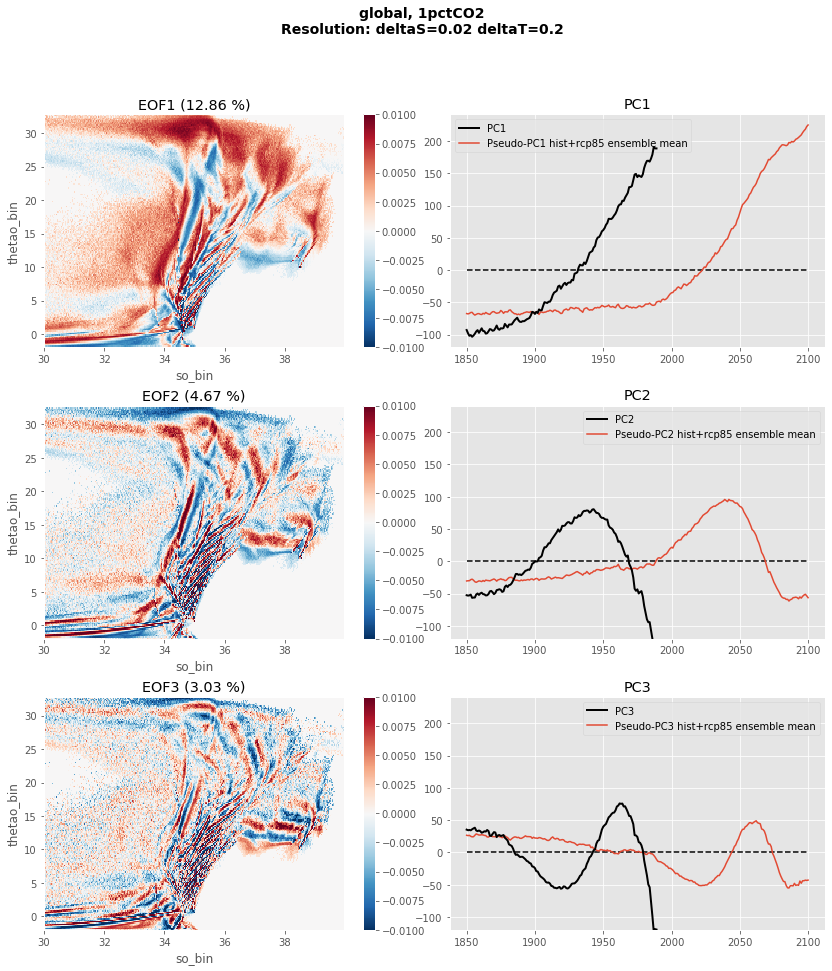

In [68]:
time=np.arange(1850,2101)
timeCO2 = np.arange(1850,1990)
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

vmin = -0.01 
vmax = 0.01 

c = eof1CO2.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1CO2))+'%)')
ax[0,1].plot(timeCO2,pcsCO2[:,0],label='PC1',lw=2,color='black',zorder=10)
ax[0,1].plot(time,pseudo_pcs_ensm[:,0],label='Pseudo-PC1 hist+rcp85 ensemble mean')
ax[0,1].legend()
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')
ylim = ax[0,1].get_ylim()

c = eof2CO2.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2CO2))+'%)')
ax[1,1].plot(timeCO2,-pcsCO2[:,1],label='PC2',lw=2,color='black',zorder=10)
ax[1,1].plot(time,-pseudo_pcs_ensm[:,1],label='Pseudo-PC2 hist+rcp85 ensemble mean')
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')
ax[1,1].set_ylim(ylim[0],ylim[1])
ax[1,1].legend()

c = eof3CO2.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3CO2))+'%)')
ax[2,1].plot(timeCO2,-pcsCO2[:,2],label='PC3',lw=2,color='black',zorder=10)
ax[2,1].plot(time,-pseudo_pcs_ensm[:,2],label='Pseudo-PC3 hist+rcp85 ensemble mean')
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')
ax[2,1].set_ylim(ylim[0],ylim[1])
ax[2,1].legend()

plt.subplots_adjust(hspace=0.25,wspace=0.08)
title = region+', 1pctCO2\nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT)
plt.suptitle(title,fontsize=14,fontweight='bold')

## Smooth EOF 1pctCO2 

In [60]:
VCO2_smooth_red = smooth_red_zeros(VCO2)

In [69]:
# -- Perform EOF 
solver_smooth_CO2=Eof(VCO2_smooth_red.stack(z=('so_bin','thetao_bin')))
pcs_smooth_CO2 = solver_smooth_CO2.pcs()
eofs_smooth_CO2 = solver_smooth_CO2.eofs()
var1_smooth_CO2 = solver_smooth_CO2.varianceFraction()[0].data*100
var2_smooth_CO2 = solver_smooth_CO2.varianceFraction()[1].data*100
var3_smooth_CO2 = solver_smooth_CO2.varianceFraction()[2].data*100
eof1_smooth_CO2 = eofs_smooth_CO2[0,:].unstack('z')
eof2_smooth_CO2 = -eofs_smooth_CO2[1,:].unstack('z')
eof3_smooth_CO2 = -eofs_smooth_CO2[2,:].unstack('z')

In [70]:
# -- Project hist+rcp85 ensemble mean on smooth 1pctCO2 EOFs
pseudo_pcs_ensmbis = solver_smooth_CO2.projectField(Vensm_red.stack(z=('so_bin', 'thetao_bin')))

Text(0.5, 0.98, 'global, 1pctCO2 temporal smoothing 10 years\nResolution: deltaS=0.02 deltaT=0.2')

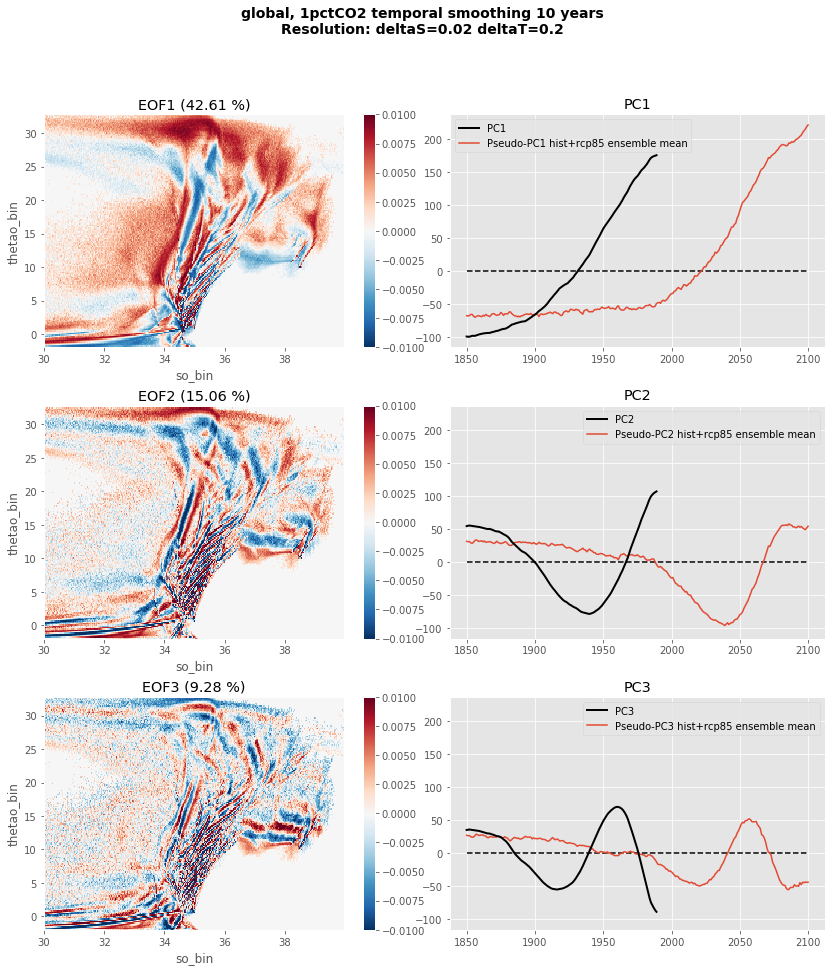

In [71]:
time=np.arange(1850,2101)
timeCO2 = np.arange(1850,1990)
fig,ax = plt.subplots(ncols=2,nrows=3,figsize=(14,15))

vmin = -0.01 
vmax = 0.01 

c = eof1_smooth_CO2.T.plot(ax=ax[0,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[0,0],label='')
ax[0,0].set_title('EOF1 ('+'%.2f '% Decimal(str(var1_smooth_CO2))+'%)')
ax[0,1].plot(timeCO2,pcs_smooth_CO2[:,0],label='PC1',lw=2,color='black',zorder=10)
ax[0,1].plot(time,pseudo_pcs_ensmbis[:,0],label='Pseudo-PC1 hist+rcp85 ensemble mean')
ax[0,1].legend()
ax[0,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[0,1].set_title('PC1')
ylim = ax[0,1].get_ylim()

c = eof2_smooth_CO2.T.plot(ax=ax[1,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[1,0],label='')
ax[1,0].set_title('EOF2 ('+'%.2f '% Decimal(str(var2_smooth_CO2))+'%)')
ax[1,1].plot(timeCO2,-pcs_smooth_CO2[:,1],label='PC2',lw=2,color='black',zorder=10)
ax[1,1].plot(time,-pseudo_pcs_ensmbis[:,1],label='Pseudo-PC2 hist+rcp85 ensemble mean')
ax[1,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[1,1].set_title('PC2')
ax[1,1].set_ylim(ylim[0],ylim[1])
ax[1,1].legend()

c = eof3_smooth_CO2.T.plot(ax=ax[2,0],add_colorbar=False,vmin=vmin,vmax=vmax,center=0,cmap='RdBu_r')
cb = fig.colorbar(c,ax=ax[2,0],label='')
ax[2,0].set_title('EOF3 ('+'%.2f '% Decimal(str(var3_smooth_CO2))+'%)')
ax[2,1].plot(timeCO2,-pcs_smooth_CO2[:,2],label='PC3',lw=2,color='black',zorder=10)
ax[2,1].plot(time,-pseudo_pcs_ensmbis[:,2],label='Pseudo-PC3 hist+rcp85 ensemble mean')
ax[2,1].hlines(0,time[0],time[-1],colors='k',linestyles='dashed')
ax[2,1].set_title('PC3')
ax[2,1].set_ylim(ylim[0],ylim[1])
ax[2,1].legend()

plt.subplots_adjust(hspace=0.25,wspace=0.08)
title = region+', 1pctCO2 temporal smoothing 10 years\nResolution: deltaS='+str(deltaS)+' deltaT='+str(deltaT)
plt.suptitle(title,fontsize=14,fontweight='bold')